In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [24]:
data = pd.read_csv('digit_recognizer_dataset/train.csv')
test = pd.read_csv('digit_recognizer_dataset/test.csv')

In [25]:
data = np.array(data)
m, n = data.shape # row, cols+1/features
np.random.shuffle(data)

data_dev = data[0: 1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1: n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1: n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [26]:
data_train.shape

(785, 41000)

In [27]:
# note: understand the function first. then merge them together later
def init_param(weight_range):
    W1 = np.random.rand(10, 784) - weight_range
    b1 = np.random.rand(10, 1) - weight_range
    W2 = np.random.rand(10, 10) - weight_range
    b2 = np.random.rand(10, 1) - weight_range
    
    return W1, b1, W2, b2


def ReLU(Z):
    return np.maximum(Z, 0) # greater than 0, return Z
    

def softmax(Z): # explain softmax function
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shifted)
    sum_exp_Z = np.sum(exp_Z, axis=0, keepdims=True)
    if np.any(sum_exp_Z == 0):
        raise ValueError("Sum of exponentials is zero, which may indicate a numerical issue.")
    
    return exp_Z / sum_exp_Z


def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1 
    one_hot_Y = one_hot_Y.T
    
    return one_hot_Y
    

def derivative_ReLU(Z):
    return Z > 0

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)    
    m = Y.size
    one_hot_Y = one_hot(Y)    
    dZ2 = A2 - one_hot_Y # Ensure shapes match (10, m)
    dW2 = 1/m * dZ2.dot(A1.T) # Ensure shapes match (10, 784) . (784, m)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True) # Shape (10, 1)
    dZ1 = W2.T.dot(dZ2) * derivative_ReLU(Z1) # Ensure shapes match (784, 10)  . (10, m) * (784, m)
    dW1 = 1 / m * dZ1.dot(X.T) # Ensure shapes match (10, 784) . (784, m)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True) # Shape (10, 1)
    
    return  dW1, db2, dW2, db1


def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha  * dW2
    b2 = b2 - alpha * db2
    
    return W1, b1, W2, b2

In [28]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return format(np.sum(predictions == Y) / Y.size, '.13f')

def gradient_descent(X, Y, iterations, alpha, initial_weight):
    accuracy_list = []

    W1, b1, W2, b2 = init_param(initial_weight)
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)    
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 50 == 0: #? explain
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            accuracy_list.append(accuracy)            
            # print("Iteration: ", i)
            # print("Accuracy: ", accuracy)
    
    return W1, b1, W2, b2, accuracy_list

**Save Result to Result Folder**

In [29]:
import os


# Save W1, b1, W2, b2 to a numpy arrays
def save_weights_to_npy(W1, b1, W2, b2, filename='weights.npz'):
    np.savez(filename, W1=W1, b1=b1, W2=W2, b2=b2)


# Example usage
def save_accuracy_to_csv(accuracy_list, filename='results.npy'):
    # Create a DataFrame from the accuracy list
    df_accuracy = pd.DataFrame(accuracy_list, columns=['Iteration', 'Accuracy'])
    
    # Save the accuracy info DataFrame to a CSV file
    df_accuracy.to_csv(filename, index=False, header=True)
    

def add_to_folder(W1, b1, W2, b2, accuracy_list, iterations, weight, grow_rate):
    # replace "." with "_" so I can add decimal as folder names
    # make grow rate as the folder path 
    grow_rate = str(grow_rate).replace('.', '_')  
    iterations = str(iterations).replace('.', '_')
    weight = str(weight).replace('.', '_')
    
    gr_folder_path = f'results/gr{grow_rate}'
    folder_path = f'i{iterations}-w{weight}-gr{grow_rate}'
    
    
    if not os.path.exists(gr_folder_path):
        # Create the folder
        os.makedirs(gr_folder_path)
    
    if not os.path.exists(folder_path):
        # Create the folder
        os.makedirs(f'{gr_folder_path}/{folder_path}')
    
    
    # Prepare data for saving
    # Results is a dictionary where each key is an iteration and value is a tuple (accuracy, W1, b1, W2, b2)
    Result_list = [[i * 50, acc] for i, acc in enumerate(accuracy_list, start=1)]
    save_accuracy_to_csv(Result_list, f'{gr_folder_path}/{folder_path}/accuracy.csv')
    save_weights_to_npy(W1, b1, W2, b2, f'{gr_folder_path}/{folder_path}/weight.npz')

In [30]:
weightList = [0.429]
grow_rate = 0.1
iterations = 5000


def result():
    accuracy_list = []

    for weight in weightList:
        W1, b1, W2, b2, accuracy = gradient_descent(X_train, Y_train, iterations, grow_rate, weight)
        accuracy = np.array(accuracy)
        accuracy_list.append(accuracy)
        
        print(f'FA: { accuracy[-1]}\n')
        add_to_folder(W1, b1, W2, b2, accuracy, iterations, weight, grow_rate)

    return W1, b1, W2, b2, accuracy_list


W1, b1, W2, b2, accuracy_list = result()
print("Weights, Accuracies")
for i in range(len(weightList)):
    print(f"{weightList[i]}: {accuracy_list[i]}")  

[2 2 0 ... 2 2 2] [2 7 5 ... 2 6 5]
[2 7 9 ... 2 6 8] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 8] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 3] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 3] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 3] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 3] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 3] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 3] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ... 2 6 5]
[2 7 8 ... 2 6 5] [2 7 5 ...

**Load Weight and Read Accuracy From Folder**

In [31]:
def load_weights_from_npy(filename='weights.npz'):
    data = np.load(filename)
    W1 = data['W1']
    b1 = data['b1']
    W2 = data['W2']
    b2 = data['b2']
    
    return W1, b1, W2, b2


def load_from_folder(iteration, weight, grow_rate):
    grow_rate = str(grow_rate).replace('.', '_')  
    iteration = str(iteration).replace('.', '_')
    weight = str(weight).replace('.', '_')
    
    folder_path = f'results/gr{grow_rate}/i{iteration}-w{weight}-gr{grow_rate}'
    
    W1, b1, W2, b2 = load_weights_from_npy(f'{folder_path}/weight.npz')
    return W1, b1, W2, b2

# W1, b1, W2, b2 = load_from_folder(200, 0.429, 0.2) # Example: load Weight from .npy.npz 
# print(W1, b1, W2, b2)

In [32]:
# W1, b1, W2, b2 = load_from_folder(200, 0.429, 0.2) # Example: load Weight from .npy.npz 
def plot_data_by_grow_rate(grow_rate):
    grow_rate = str(grow_rate).replace('.', '_')  
    list_dir = os.listdir(f'results/gr{grow_rate}/') # list all result from results/gr{grow_rate} folder
        
    
    for dir in list_dir:
        print(f"{dir}")
        df = pd.read_csv(f'results/gr{grow_rate}/{dir}/accuracy.csv')
        # Step 2: Plot the data
        plt.plot(df['Iteration'], df['Accuracy'], marker='o')  # 'o' adds markers to each data point
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over Iterations')
        plt.grid(True)  # Optional: Adds a grid for easier reading
        plt.show()

# plot_data_by_grow_rate(0.2)

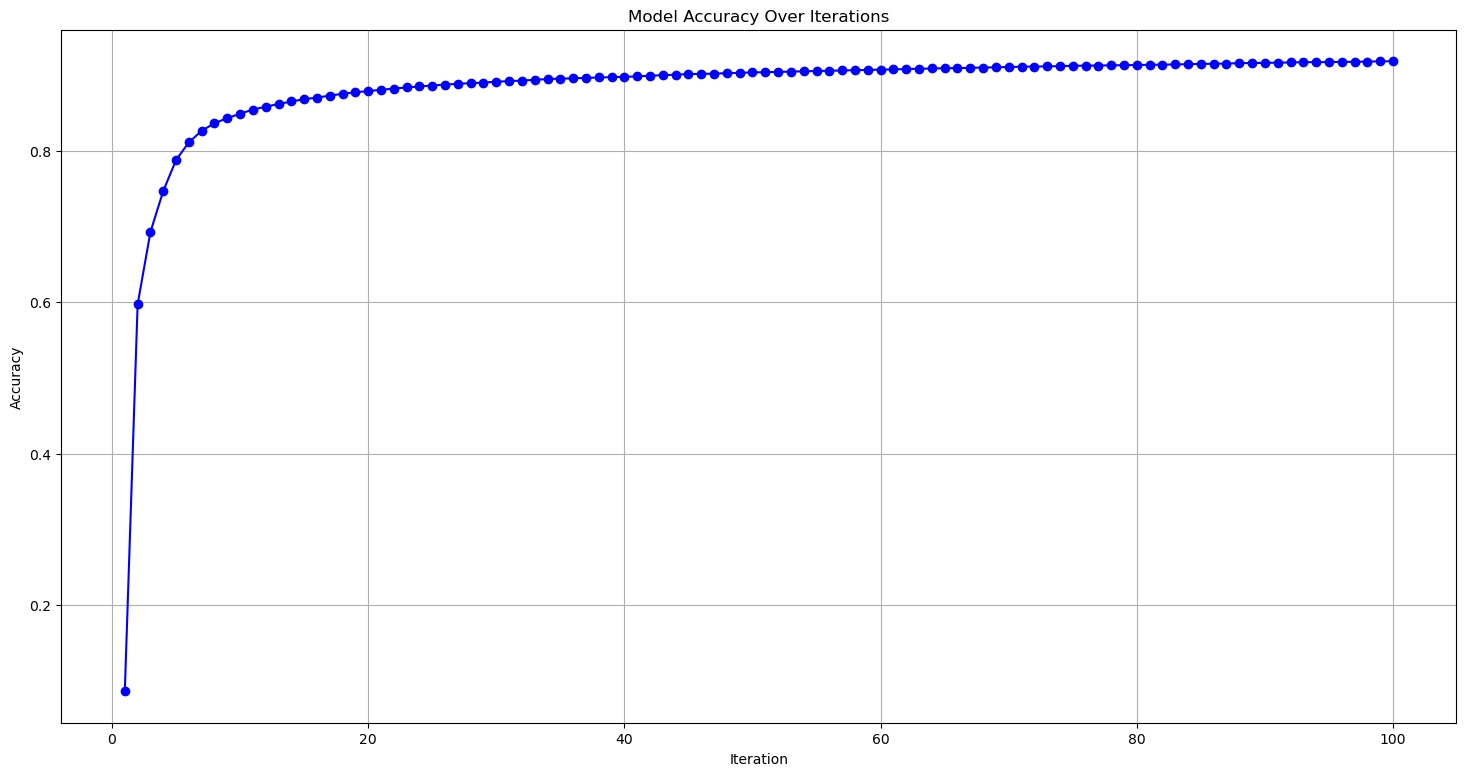

In [33]:
# Get accuracy from accuracyList
for i in range(len(accuracy_list)):
    accuracy = accuracy_list[i]
    
    # Assuming 'accuracy' is your NumPy array containing accuracy values
    iterations = range(1, len(accuracy) + 1)  # If accuracy was recorded every iteration, adjust accordingly
    
    accuracy = np.array([float(acc) for acc in accuracy])
    
    plt.figure(figsize=(18, 9))  # Optional: Creates a figure of size 10x6 inches
    plt.plot(iterations, accuracy, marker='o', linestyle='-', color='b')  # Plots accuracy values, with 'o' markers
    plt.title('Model Accuracy Over Iterations')  # Adds a title
    plt.xlabel('Iteration')  # Adds a label to the x-axis
    plt.ylabel('Accuracy')  # Adds a label to the y-axis
    plt.grid(True)  # Optional: Adds a grid for easier reading
    plt.show()  # Displays the plot

In [34]:
# data_test = test[1000:m].T
# Y_test = data_test[0]
# X_test = data_test[1: n]
# X_test = X_test / 255.

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


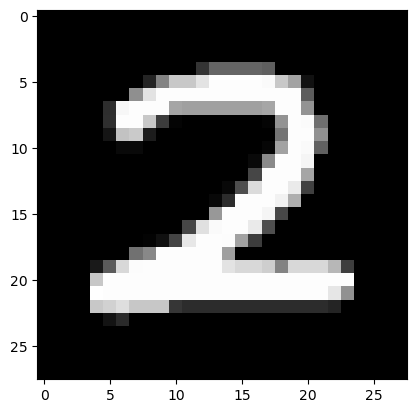

In [35]:
# W1, b1, W2, b2 = load_from_folder(200, 0.429, 0.2) # load Weight from .npy.npz 
test_prediction(0, W1, b1, W2, b2) 

In [36]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[1 8 6 0 0 9 3 2 2 8 5 0 3 3 8 1 5 2 5 2 5 4 9 2 0 8 0 5 3 7 5 9 1 3 3 3 2
 9 0 7 3 3 2 6 1 7 8 8 5 4 0 7 7 2 6 3 5 2 8 8 8 0 5 8 3 9 0 1 8 2 2 2 3 7
 4 1 5 5 8 6 6 7 7 7 1 4 1 9 7 8 4 2 5 6 5 1 2 7 1 9 1 6 5 1 6 4 4 2 3 1 8
 5 8 9 3 1 1 2 9 1 0 3 2 8 7 4 0 6 9 9 0 1 3 5 7 4 4 9 4 8 9 0 1 8 8 5 6 4
 8 6 8 4 6 9 5 1 9 2 3 8 3 9 2 7 9 4 8 4 0 3 6 5 7 5 1 4 2 6 8 7 6 9 0 2 8
 8 4 7 0 1 2 5 8 3 3 2 8 6 8 6 3 7 6 9 4 3 1 4 8 2 1 4 9 7 1 5 9 4 5 9 1 7
 7 1 0 0 2 4 9 2 8 0 4 3 7 3 1 0 2 0 3 9 0 2 1 8 0 1 6 6 2 3 6 1 2 3 5 9 7
 4 2 1 3 1 5 4 8 7 5 5 3 4 9 6 5 5 4 2 3 0 3 1 4 2 0 3 9 8 2 7 6 2 5 0 0 2
 1 5 7 7 3 6 3 4 1 6 4 4 9 8 5 4 2 8 9 8 9 0 2 9 4 2 2 8 0 0 2 6 6 3 2 6 1
 1 4 1 9 8 1 1 7 7 5 5 4 7 9 0 3 6 1 8 0 4 3 7 1 7 3 8 0 7 6 7 1 9 7 5 3 7
 9 7 5 5 8 7 0 0 1 9 9 5 5 6 5 3 0 5 1 7 0 0 0 9 8 5 6 8 9 2 8 3 0 3 1 3 4
 6 6 9 6 4 3 1 9 7 7 1 0 5 8 9 6 1 0 7 3 9 4 1 0 1 9 4 6 3 4 4 5 5 7 5 3 7
 4 7 5 9 1 6 4 1 1 9 3 2 7 1 9 5 6 1 8 0 7 1 8 6 1 9 7 4 3 0 8 3 4 1 9 7 0
 0 1 3 1 3 1 2 6 9 4 6 0 

'0.9070000000000'